<a href="https://www.kaggle.com/code/darvack/transformer-paper-regression2?scriptVersionId=142400347" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
random.seed(42)
np.random.seed(42)

Here, we have loaded the data and set Furan as the label.
At first, we have used KFold Round-Robin for testing our model so that every data points gets tested 1 time.

In [2]:
ds_A = pd.read_csv("/kaggle/input/transformer/DatasetA.csv").sample(frac=1, random_state=42).reset_index(drop=True)
ds_B = pd.read_csv("/kaggle/input/transformer/DatasetB.csv").sample(frac=1, random_state=42).reset_index(drop=True)

ds_A_new = ds_A.drop(set(ds_A.columns) - set(ds_B.columns), axis=1)
ds_B_new = ds_B[ds_A_new.columns]

ds_mix = pd.concat([ds_A_new, ds_B_new]).sample(frac=1, random_state=42).reset_index(drop=True)
y_mix = ds_mix['Furan']
X_mix = ds_mix.drop(["Furan", "HI"], axis = 1)

y_A = ds_A['Furan']
X_A = ds_A.drop(["Furan", "HI"], axis=1)

y_B = ds_B['Furan']
X_B = ds_B.drop(["Furan", "HI"], axis=1)

y_stratify = pd.DataFrame(y_A.copy())
bins = [-1, 0.1, 1, 100]
labels = [0, 1, 2]
y_stratify['Class'] = pd.cut(y_stratify['Furan'], bins=bins, labels=labels)
y_stratify = y_stratify.drop(["Furan"], axis=1)

In [3]:
#ds_A.hist(bins=50, figsize=(20,15))

The code below, drops the columns that we don't need, and only keeps the common features between dataset A and B.

In [4]:
X_A = X_A.drop(set(ds_A.columns) - set(ds_B.columns), axis=1)
X_B = X_B[X_A.columns]
X_A

,H2,Methane,Acetylene,Ethylene,Ethane,Water,Acid,BDV,IFT
0,22.6,0.0,0.0,0.5,0.7,6,0.005,51.0,30
1,8.9,5.1,2.7,2.9,3.3,24,0.019,36.0,26
2,13.4,14.8,0.0,1.4,2.2,3,0.005,77.0,31
3,18.5,12.4,0.0,0.9,3.2,8,0.005,51.0,32
4,19.9,31.0,0.0,2.1,26.8,3,0.005,80.0,32
...,...,...,...,...,...,...,...,...,...
725,13.9,2.1,0.0,1.1,2.1,6,0.026,73.0,27
726,42.5,4.7,0.0,1.0,2.0,3,0.005,68.0,37
727,12.7,12.7,0.0,0.3,1.2,5,0.005,81.0,36
728,10.3,0.5,0.0,0.0,0.0,5,0.005,51.0,35


The code below performs feature selection via step-wise regression or SequentialFeatureSelector. "n_features_to_select" is a hyperparameter that defines how many feature we'd like to keep which needs to be fine tuned. In our experiment, 6 or 7 features to keep, results in better models.

In [5]:
'''from sklearn.feature_selection import SequentialFeatureSelector
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

for i in range(1,9):
    rf_reg = RandomForestRegressor(min_samples_split=12, min_samples_leaf=1, random_state=42)
    
    xgb_reg = XGBRegressor(learning_rate=0.01, n_estimators=300, max_depth=3, subsample=0.7)

    sfs = SequentialFeatureSelector(rf_reg,
                                    n_features_to_select=i,
                                    direction='backward',
                                    scoring='neg_mean_squared_error',
                                    cv=4)

    sfs.fit(X_A, y_A)

    # Print the selected features
    print("Selected features" + f"{i}:", sfs.get_feature_names_out())
'''

useful_features1 = ['IFT']
useful_features2 = ['Methane', 'IFT']
useful_features3 = ['Methane', 'Ethane', 'IFT']
useful_features4 = ['Methane', 'Ethane', 'Water', 'IFT']
useful_features5 = ['Methane', 'Ethylene', 'Ethane', 'BDV', 'IFT']
useful_features6 = ['Methane', 'Ethylene', 'Ethane', 'Water', 'BDV', 'IFT']
useful_features7 = ['H2', 'Methane', 'Acetylene', 'Ethylene', 'Ethane', 'BDV', 'IFT']
useful_features8 = ['H2', 'Methane', 'Ethylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']

In [6]:
Selectedfeatures5 = ['H2', 'Ethane', 'Water', 'Acid', 'IFT']
Selectedfeatures6 = ['H2', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']
Selectedfeatures7 = ['H2', 'Acetylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']
Selectedfeatures8 = ['H2', 'Acetylene', 'Ethylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']

In [7]:
Selected_features1 = ['Acid']
Selected_features2 = ['Water', 'Acid']
Selected_features3 = ['Ethane', 'Water', 'Acid']
Selected_features4 = ['Ethane', 'Water', 'Acid', 'IFT']
Selected_features5 = ['Ethane', 'Water', 'Acid', 'BDV', 'IFT']
Selected_features6 = ['Acetylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']
Selected_features7 = ['H2', 'Acetylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']
Selected_features8 = ['H2', 'Acetylene', 'Ethylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']

# Removing outliers

In [8]:
# For Dataset A
means = X_A.mean()
stds = X_A.std()

# Identify outliers 
outliers_A = X_A[(np.abs(X_A - means) > 3 * stds).any(axis=1)]

# Remove outliers 
X_A = X_A[~X_A.index.isin(outliers_A.index)]
y_A = y_A[~y_A.index.isin(outliers_A.index)]


# For Dataset B:
means = X_B.mean()
stds = X_B.std()

# Identify outliers 
outliers_B = X_B[(np.abs(X_B - means) > 3 * stds).any(axis=1)]

# Remove outliers 
X_B = X_B[~X_B.index.isin(outliers_B.index)]
y_B = y_B[~y_B.index.isin(outliers_B.index)]


# For Dataset mix:
means = X_mix.mean()
stds = X_mix.std()

# Identify outliers 
outliers_mix = X_mix[(np.abs(X_mix - means) > 3 * stds).any(axis=1)]

# Remove outliers 
X_mix = X_mix[~X_mix.index.isin(outliers_mix.index)]
y_mix = y_mix[~y_mix.index.isin(outliers_mix.index)]

# Standard Scaling

In [9]:
X_A = (X_A - X_A.mean())/X_A.std()
X_B = (X_B - X_B.mean())/X_B.std()
X_mix = (X_mix - X_mix.mean())/X_mix.std()

# Correlation Matrix and Mutual Information

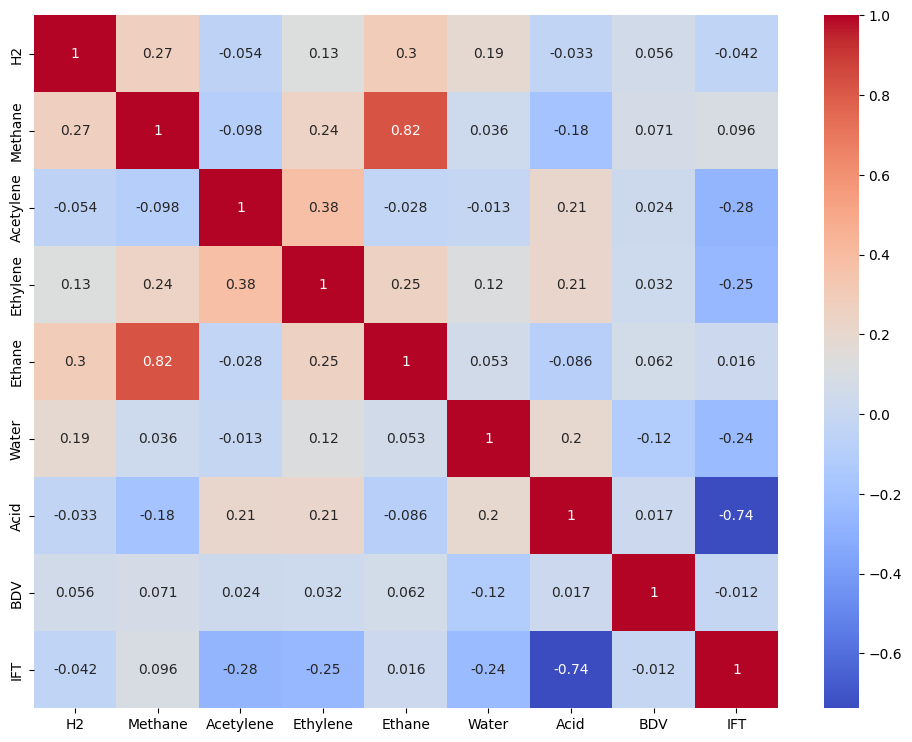

In [10]:
corr_matrix = X_A.corr()
import seaborn as sns
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

#plt.text(0.5, -0.1, "Correlation Matrix for utility A", size=12, ha='center', va='bottom')
plt.show()

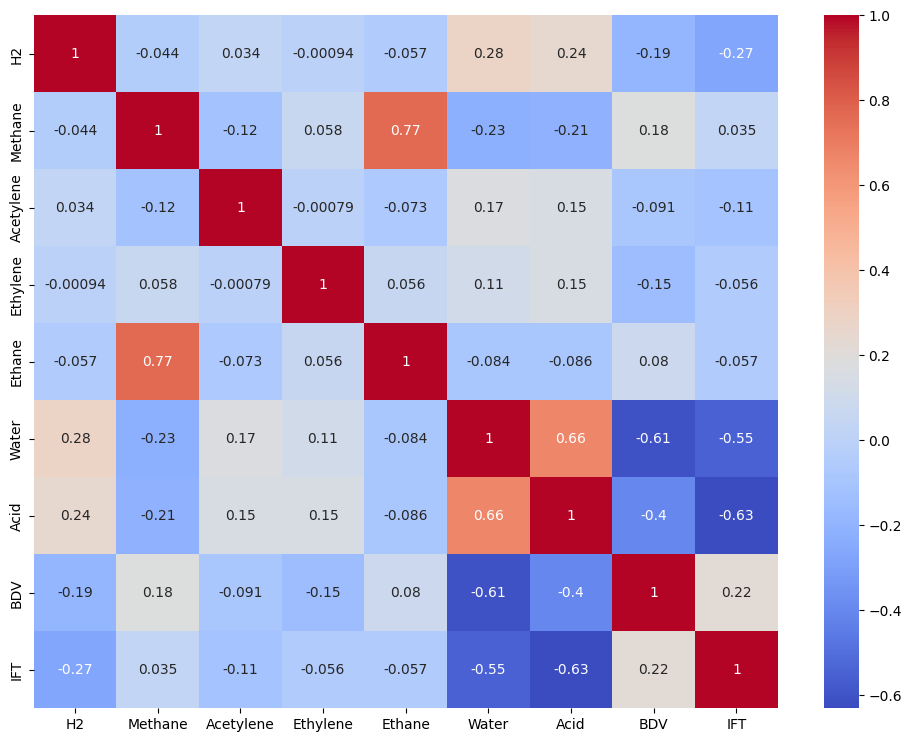

In [11]:
corr_matrix = X_B.corr()
import seaborn as sns
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

#plt.text(0.5, -0.1, "Correlation Matrix for utility B", size=12, ha='center', va='bottom')
plt.show()

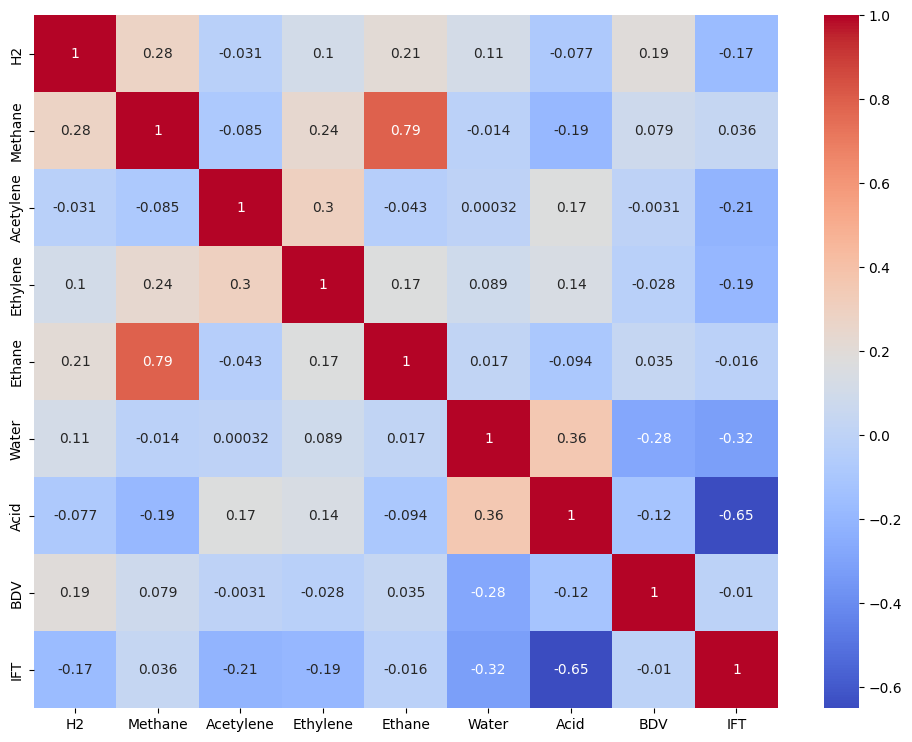

In [12]:
corr_matrix = X_mix.corr()
import seaborn as sns
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

#plt.text(0.5, -0.1, "Correlation Matrix for utility B", size=12, ha='center', va='bottom')
plt.show()

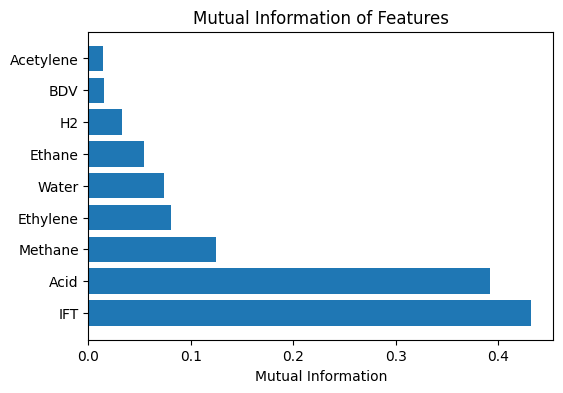

In [13]:
from sklearn.feature_selection import mutual_info_regression

# Compute the mutual information between all pairs of columns
mi_matrix = mutual_info_regression(X_A, y_A, random_state=0)

# Convert the mutual information scores to a DataFrame
mi_df = pd.DataFrame(mi_matrix, index=X_A.columns, columns=['Mutual Information'])

# Sort the DataFrame by mutual information score in descending order
mi_df = mi_df.sort_values(by=['Mutual Information'], ascending=False)

# Plot the mutual information scores as a horizontal bar chart
plt.figure(figsize=(6, 4))
plt.barh(mi_df.index, mi_df['Mutual Information'])
plt.xlabel('Mutual Information')
plt.title('Mutual Information of Features')
plt.show()

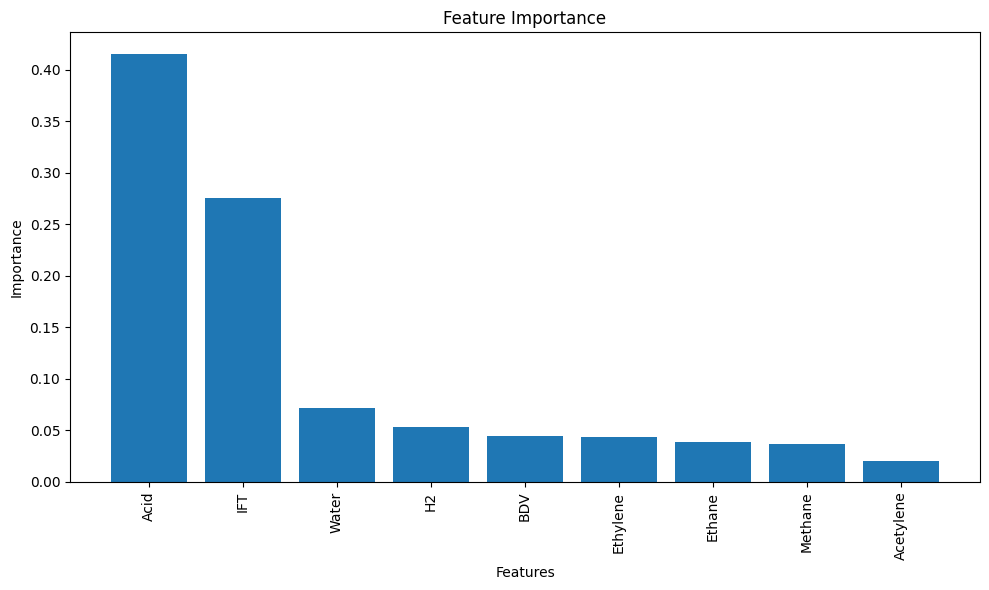

In [14]:
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor

# Train the ExtraTreesClassifier model
model = ExtraTreesRegressor(random_state=45)
model.fit(X_A, y_A)

# Obtain the feature importances from the trained model
importances = model.feature_importances_

# Sort the feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]

# Get the feature names in the original order
feature_names = X_A.columns[sorted_indices]

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

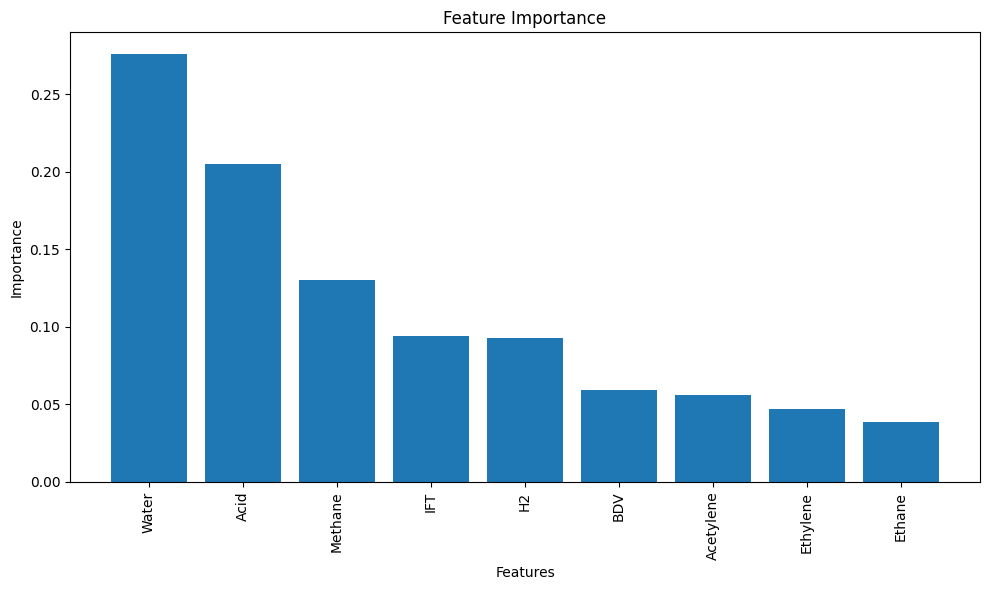

In [15]:
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor

# Train the ExtraTreesClassifier model
model = ExtraTreesRegressor(random_state=45)
model.fit(X_B, y_B)

# Obtain the feature importances from the trained model
importances = model.feature_importances_

# Sort the feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]

# Get the feature names in the original order
feature_names = X_B.columns[sorted_indices]

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

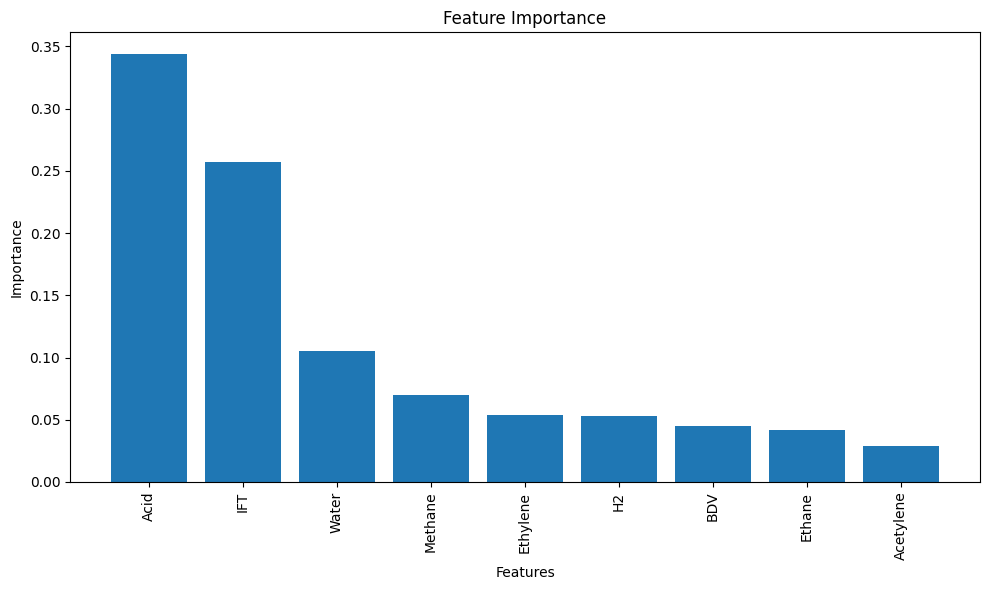

In [16]:
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor

# Train the ExtraTreesClassifier model
model = ExtraTreesRegressor(random_state=45)
model.fit(X_mix, y_mix)

# Obtain the feature importances from the trained model
importances = model.feature_importances_

# Sort the feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]

# Get the feature names in the original order
feature_names = X_mix.columns[sorted_indices]

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# First case: Training using 75% of the data and testing on the remaining 25% with Round-Robin (KFold)

Importing libraries

In [17]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsRegressor

Here is a comparison of different models.

**Random forest model**

In [18]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
reg = RandomForestRegressor(min_samples_split=12, min_samples_leaf=1, random_state=42)
scoring = 'neg_mean_squared_error'

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A, y_A, cv=4)
mae_scores = cross_val_score(reg, X_A, y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

RandomForestRegressor for dataset A:
MSE Scores: [0.57398357 0.17878687 0.17469908 0.27275149]
Mean MSE: 0.30005525157362456
R2 Scores: [0.55836484 0.56562067 0.61206736 0.4336929 ]
Mean R2: 0.5424364392672665
MAE Scores: [0.30778532 0.16866834 0.1672423  0.20045014]
Mean MAE: 0.2110365261050937 

RandomForestRegressor for dataset A with feature selection:
MSE Scores: [0.57510367 0.17856504 0.15801583 0.27847814]
Mean MSE: 0.29754066992262085
R2 Scores: [0.557503   0.56615964 0.6491138  0.42180278]
Mean R2: 0.5486448051071289
MAE Scores: [0.30845496 0.17332536 0.16287032 0.19912098]
Mean MAE: 0.21094290491350062 

MSE Score for dataset B without feature selection: 0.7066290176942751
R2 Score for dataset B without feature selection: 0.04534639142279906
MAE Score for dataset B without feature selection: 0.335707371226802 

MSE Score for dataset B with feature selection: 0.6208493165812511
R2 Score for dataset B with feature selection: 0.16123450125082206
MAE Score for dataset B with feat

**Extra Tree Regressor**

In [19]:
from sklearn.ensemble import ExtraTreesRegressor

reg = ExtraTreesRegressor(random_state=41)

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A, y_A, cv=4)
mae_scores = cross_val_score(reg, X_A, y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

ExtraTreesRegressor for dataset A:
MSE Scores: [0.50188005 0.15175645 0.21576838 0.22684451]
Mean MSE: 0.2740623493851696
R2 Scores: [0.61384281 0.63129359 0.52086984 0.5290084 ]
Mean R2: 0.5737536618440584
MAE Scores: [0.28760783 0.16643654 0.18567589 0.18663753]
Mean MAE: 0.2065894479129259 

ExtraTreesRegressor for dataset A with feature selection:
MSE Scores: [0.49811225 0.16602413 0.18190191 0.20013596]
Mean MSE: 0.2615435618294339
R2 Scores: [0.61674184 0.59662895 0.59607292 0.5844627 ]
Mean R2: 0.5984766024820466
MAE Scores: [0.28959852 0.17528812 0.17838651 0.17502869]
Mean MAE: 0.2045754641627891 

MSE Score for dataset B without feature selection: 0.6870731546345633
R2 Score for dataset B without feature selection: 0.07176630168874387
MAE Score for dataset B without feature selection: 0.3436061524340067 

MSE Score for dataset B with feature selection: 0.6893534765735749
R2 Score for dataset B with feature selection: 0.06868559383032835
MAE Score for dataset B with feature se

**Feature Selection for ExtraTrees for the first scenario**

In [20]:
Selectedfeatures7

['H2', 'Acetylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']

In [21]:
featuress = ['H2', 'Methane', 'Ethane', 'BDV', 'IFT', 'Water', 'Acid']

In [22]:
from sklearn.ensemble import ExtraTreesRegressor

reg = ExtraTreesRegressor(random_state=41)

scores = cross_val_score(reg, X_A[featuress], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[featuress], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[featuress], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

ExtraTreesRegressor for dataset A with feature selection:
MSE Scores: [0.52566746 0.1467614  0.17902213 0.2246451 ]
Mean MSE: 0.269024022135535
R2 Scores: [0.59554028 0.64342952 0.6024677  0.533575  ]
Mean R2: 0.5937531227544524
MAE Scores: [0.29461607 0.16971784 0.17243219 0.1875716 ]
Mean MAE: 0.20608442419231152 



**Feature Selection for ExtraTrees for the second scenario**

In [23]:
reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

MSE Score for dataset B without feature selection: 0.6870731546345633
R2 Score for dataset B without feature selection: 0.07176630168874387
MAE Score for dataset B without feature selection: 0.3436061524340067 



In [24]:
Selected_features_extratrees = ['H2', 'Methane', 'Acetylene', 'Ethane', 'Water', 'Acid', 'IFT', 'BDV']

In [25]:
reg = ExtraTreesRegressor(random_state=42)
reg.fit(X_A[Selected_features_extratrees], y_A)
y_pred_B = reg.predict(X_B[Selected_features_extratrees])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

MSE Score for dataset B with feature selection: 0.6515178006074277
R2 Score for dataset B with feature selection: 0.11980147456771906
MAE Score for dataset B with feature selection: 0.34019551576380475


In [26]:
Selected_featuress6 = ['H2', 'Methane', 'Acetylene', 'Ethane', 'Water', 'Acid', 'IFT', 'BDV']

**XGB Model:**

In [27]:
reg = XGBRegressor(random_state=42, learning_rate=0.005, n_estimators=500, max_depth=5, subsample=0.95)

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A, y_A, cv=4)
mae_scores = cross_val_score(reg, X_A, y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

XGBRegressor for dataset A:
MSE Scores: [0.69801285 0.21884762 0.14497202 0.19002685]
Mean MSE: 0.3129648344351783
R2 Scores: [0.46293407 0.46828937 0.67807855 0.605452  ]
Mean R2: 0.5536884960855355
MAE Scores: [0.33623298 0.21021271 0.17673859 0.1940567 ]
Mean MAE: 0.22931024647391532 

XGBRegressor for dataset A with feature selection:
MSE Scores: [0.66608761 0.21200202 0.13734361 0.1979325 ]
Mean MSE: 0.3033414346555336
R2 Scores: [0.48749803 0.48492137 0.69501803 0.58903769]
Mean R2: 0.5641187808012338
MAE Scores: [0.32993889 0.20976646 0.17942276 0.19814066]
Mean MAE: 0.22931719190008226 

MSE Score for dataset B without feature selection: 0.5718469275673665
R2 Score for dataset B without feature selection: 0.22743657663919548
MAE Score for dataset B without feature selection: 0.3141436978134041 

MSE Score for dataset B with feature selection: 0.6422054665667478
R2 Score for dataset B with feature selection: 0.13238240893865605
MAE Score for dataset B with feature selection: 0.3

**Feature selection for XGB**

In [28]:
reg = XGBRegressor(random_state=42, learning_rate=0.005, n_estimators=500, max_depth=5, subsample=0.95)

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

XGBRegressor for dataset A with feature selection:
MSE Scores: [0.66608761 0.21200202 0.13734361 0.1979325 ]
Mean MSE: 0.3033414346555336
R2 Scores: [0.48749803 0.48492137 0.69501803 0.58903769]
Mean R2: 0.5641187808012338
MAE Scores: [0.32993889 0.20976646 0.17942276 0.19814066]
Mean MAE: 0.22931719190008226 



In [29]:
Selectedfeatures7

['H2', 'Acetylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']

**Feature selection for XGB for second scenario**

In [30]:
xgb_features = ['Acetylene', 'Ethylene', 'Water', 'Acid', 'BDV', 'IFT']

In [31]:

reg.fit(X_A[xgb_features], y_A)
y_pred_B = reg.predict(X_B[xgb_features])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

MSE Score for dataset B with feature selection: 0.5422596477308005
R2 Score for dataset B with feature selection: 0.267408899819648
MAE Score for dataset B with feature selection: 0.29626286465842716


In [32]:
'''from sklearn.feature_selection import SequentialFeatureSelector

reg = XGBRegressor(random_state=42, learning_rate=0.005, n_estimators=500, max_depth=5, subsample=0.95)


for i in range(5,9):
    sfs = SequentialFeatureSelector(reg,
                                    n_features_to_select=i,
                                    direction='backward',
                                    scoring='neg_mean_squared_error',
                                    cv=4)

    sfs.fit(X_A, y_A)

    # Print the selected features
    print("Selected features" + f"{i}:", sfs.get_feature_names_out())'''

'from sklearn.feature_selection import SequentialFeatureSelector\n\nreg = XGBRegressor(random_state=42, learning_rate=0.005, n_estimators=500, max_depth=5, subsample=0.95)\n\n\nfor i in range(5,9):\n    sfs = SequentialFeatureSelector(reg,\n                                    n_features_to_select=i,\n                                    direction=\'backward\',\n                                    scoring=\'neg_mean_squared_error\',\n                                    cv=4)\n\n    sfs.fit(X_A, y_A)\n\n    # Print the selected features\n    print("Selected features" + f"{i}:", sfs.get_feature_names_out())'

**KNN Model:**

In [33]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
reg = KNeighborsRegressor(n_neighbors=5)
scoring = 'neg_mean_squared_error'

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A, y_A, cv=4)
mae_scores = cross_val_score(reg, X_A, y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

KNeighborsRegressor for dataset A:
MSE Scores: [0.62995614 0.16496179 0.21238804 0.2275418 ]
Mean MSE: 0.30871194365115956
R2 Scores: [0.51529834 0.59921    0.52837614 0.52756064]
Mean R2: 0.5426112807093473
MAE Scores: [0.31579966 0.16298113 0.16567975 0.19351139]
Mean MAE: 0.2094929820664159 

KNeighborsRegressor for dataset A with feature selection:
MSE Scores: [0.63400546 0.16739758 0.16656141 0.2532884 ]
Mean MSE: 0.30531321192410366
R2 Scores: [0.51218272 0.593292   0.63013769 0.47410362]
Mean R2: 0.5524290050460751
MAE Scores: [0.3248311  0.16644025 0.14954304 0.18979678]
Mean MAE: 0.20765279273566 

MSE Score for dataset B without feature selection: 0.7348768593711329
R2 Score for dataset B without feature selection: 0.00718364503669322
MAE Score for dataset B without feature selection: 0.3097087235993266 

MSE Score for dataset B with feature selection: 0.6517713654013012
R2 Score for dataset B with feature selection: 0.11945890931860237
MAE Score for dataset B with feature se

**Feature Selection for KNN**

In [34]:
reg = KNeighborsRegressor(n_neighbors=5)

scores = cross_val_score(reg, X_A[featuress], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[featuress], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[featuress], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

KNeighborsRegressor for dataset A with feature selection:
MSE Scores: [0.59935867 0.14472003 0.15951526 0.21389861]
Mean MSE: 0.27937314174837913
R2 Scores: [0.53884069 0.64838924 0.64578419 0.55588765]
Mean R2: 0.597225444226315
MAE Scores: [0.31837827 0.15633962 0.15097089 0.17939862]
Mean MAE: 0.20127185028015285 



**Feature Selection for KNN for second scenario**

In [35]:
knn_features = ['Acetylene', 'Ethylene', 'Water', 'Acid', 'BDV', 'IFT']

In [36]:
reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

MSE Score for dataset B without feature selection: 0.7348768593711329
R2 Score for dataset B without feature selection: 0.00718364503669322
MAE Score for dataset B without feature selection: 0.3097087235993266 



In [37]:
reg.fit(X_A[knn_features], y_A)
y_pred_B = reg.predict(X_B[knn_features])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

MSE Score for dataset B with feature selection: 0.627373805134621
R2 Score for dataset B with feature selection: 0.15241993747601523
MAE Score for dataset B with feature selection: 0.3186017141111111


In [38]:
'''from sklearn.feature_selection import SequentialFeatureSelector

reg = KNeighborsRegressor(n_neighbors=5)

for i in range(5,9):
    sfs = SequentialFeatureSelector(reg,
                                    n_features_to_select=i,
                                    direction='backward',
                                    scoring='neg_mean_squared_error',
                                    cv=4)

    sfs.fit(X_A, y_A)

    # Print the selected features
    print("Selected features" + f"{i}:", sfs.get_feature_names_out())'''

'from sklearn.feature_selection import SequentialFeatureSelector\n\nreg = KNeighborsRegressor(n_neighbors=5)\n\nfor i in range(5,9):\n    sfs = SequentialFeatureSelector(reg,\n                                    n_features_to_select=i,\n                                    direction=\'backward\',\n                                    scoring=\'neg_mean_squared_error\',\n                                    cv=4)\n\n    sfs.fit(X_A, y_A)\n\n    # Print the selected features\n    print("Selected features" + f"{i}:", sfs.get_feature_names_out())'

In [39]:
knn_features = ['Acetylene', 'Ethylene', 'Water', 'Acid', 'BDV', 'IFT']

# Stacking Model:
This model consists of ridge regression, AdaBoost, Bayesian ARD regression and a random forest model. It takes the output of these models and stack their cross-validation to form the training set of a meta-model. The meta-model train on this new dataset and outputs the final prediction.

The features below are selected by step-wise regression.

In [40]:
Selectedfeatures1 = ['Acid']
Selectedfeatures2 = ['Water', 'Acid']
Selectedfeatures3 = ['Ethane', 'Water', 'Acid']
Selectedfeatures4 = ['Ethane', 'Water', 'Acid', 'IFT']
Selectedfeatures5 = ['Ethane', 'Water', 'Acid', 'BDV', 'IFT']
Selectedfeatures6 = ['Acetylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']
Selectedfeatures7 = ['H2', 'Acetylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']
Selectedfeatures8 = ['H2', 'Acetylene', 'Ethylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']

**Final Stacking Model for All Metrics**

In [41]:
Selectedfeatures7

['H2', 'Acetylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']

In [42]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge, ElasticNet, LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR

estimators = [#('ridge', Ridge(alpha=1)),
              #('ada', AdaBoostRegressor(random_state=42, n_estimators=200, learning_rate=0.003)),
              #('bay', BayesianRidge()),
              ('knn', KNeighborsRegressor(n_neighbors=5)),
              ('extra', ExtraTreesRegressor(random_state=41)),
              ('xgb', XGBRegressor(random_state=42, learning_rate=0.005, n_estimators=500, max_depth=5, subsample=0.95)),
              #('rf', RandomForestRegressor(min_samples_split=2, min_samples_leaf=1, random_state=41))
             ]

final_estimator = LinearRegression()

reg = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator, cv=5)

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A, y_A, cv=4)
mae_scores = cross_val_score(reg, X_A, y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

StackingRegressor for dataset A:
MSE Scores: [0.52994787 0.15636759 0.17585067 0.21417696]
Mean MSE: 0.2690857725816207
R2 Scores: [0.59224684 0.6200904  0.60951016 0.55530972]
Mean R2: 0.594289279734511
MAE Scores: [0.29302403 0.16267717 0.15991959 0.18223375]
Mean MAE: 0.19946363650327295 

StackingRegressor for dataset A with feature selection:
MSE Scores: [0.51457463 0.15112464 0.15472388 0.20673103]
Mean MSE: 0.2567885457390798
R2 Scores: [0.60407533 0.63282863 0.65642381 0.57076953]
Mean R2: 0.6160243257856662
MAE Scores: [0.29189722 0.16236923 0.16239496 0.17588439]
Mean MAE: 0.19813644995930266 

MSE Score for dataset B without feature selection: 0.6744023123206517
R2 Score for dataset B without feature selection: 0.08888457030748587
MAE Score for dataset B without feature selection: 0.3334166661541428 

MSE Score for dataset B with feature selection: 0.622577431820904
R2 Score for dataset B with feature selection: 0.15889982292844707
MAE Score for dataset B with feature select

**Testing different feature combinations**

In [43]:
reg.fit(X_A[Selectedfeatures5], y_A)
y_pred_B = reg.predict(X_B[Selectedfeatures5])
print(reg.__class__.__name__ + " for dataset B:", mean_squared_error(y_B, y_pred_B))

StackingRegressor for dataset B: 0.5741796357102488


In [44]:
useful_features6

['Methane', 'Ethylene', 'Ethane', 'Water', 'BDV', 'IFT']

**With MLP as the meta-model**

In [45]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor

estimators = [#('ridge', Ridge(alpha=1)),
              #('ada', AdaBoostRegressor(random_state=42, n_estimators=200, learning_rate=0.003)),
              ('bay', BayesianRidge()),
              ('knn', KNeighborsRegressor(n_neighbors=5)),
              ('extra', ExtraTreesRegressor(random_state=41)),
              #('svr', LinearSVR(max_iter=100000, random_state=41)),
              ('xgb', XGBRegressor(random_state=41, learning_rate=0.005, n_estimators=500, max_depth=5, subsample=0.95)),
              #('rf', RandomForestRegressor(min_samples_split=2, min_samples_leaf=1, random_state=41))
             ]

final_estimator = MLPRegressor(hidden_layer_sizes=(20,20),random_state=41, max_iter=50000, activation='tanh')

reg = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator, cv=10)

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A, y_A, cv=4)
mae_scores = cross_val_score(reg, X_A, y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_1 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B without feature selection:", mse_score)
print("R2 Score for dataset B without feature selection:", r2_score_1)
print("MAE Score for dataset B without feature selection:", mae_score,"\n")

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

StackingRegressor for dataset A:
MSE Scores: [0.59683554 0.17855748 0.22035992 0.19003744]
Mean MSE: 0.29644759551099437
R2 Scores: [0.54078204 0.56617799 0.51067397 0.60543001]
Mean R2: 0.5557660043289098
MAE Scores: [0.30522685 0.16962283 0.17412977 0.18947839]
Mean MAE: 0.20961446347962548 

StackingRegressor for dataset A with feature selection:
MSE Scores: [0.59321798 0.17616765 0.18318715 0.19537203]
Mean MSE: 0.28698620275300424
R2 Scores: [0.54356547 0.5719843  0.59321895 0.59435394]
Mean R2: 0.575780664547128
MAE Scores: [0.30692328 0.17718082 0.17081061 0.18380955]
Mean MAE: 0.20968106506564757 

MSE Score for dataset B without feature selection: 0.6217738111974618
R2 Score for dataset B without feature selection: 0.15998551189519716
MAE Score for dataset B without feature selection: 0.28877419898358486 

MSE Score for dataset B with feature selection: 0.6272282367392906
R2 Score for dataset B with feature selection: 0.15261659992606635
MAE Score for dataset B with feature se

**Feature selection for stacked regression model for second scenario**

**With Feature Selection**

In [46]:
knn_features

['Acetylene', 'Ethylene', 'Water', 'Acid', 'BDV', 'IFT']

In [47]:
estimators = [#('ridge', Ridge(alpha=1)),
              #('ada', AdaBoostRegressor(random_state=42, n_estimators=200, learning_rate=0.003)),
              #('bay', BayesianRidge()),
              ('knn', KNeighborsRegressor(n_neighbors=5)),
              ('extra', ExtraTreesRegressor(random_state=41)),
              ('xgb', XGBRegressor(random_state=42, learning_rate=0.005, n_estimators=500, max_depth=5, subsample=0.95)),
              #('rf', RandomForestRegressor(min_samples_split=2, min_samples_leaf=1, random_state=41))
             ]

final_estimator = LinearRegression()

reg = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator, cv=5)


reg.fit(X_A[knn_features], y_A)
y_pred_B = reg.predict(X_B[knn_features])
mse_score = mean_squared_error(y_B, y_pred_B)
r2_score_2 = r2_score(y_B, y_pred_B)
mae_score = mean_absolute_error(y_B, y_pred_B)
print("MSE Score for dataset B with feature selection:", mse_score)
print("R2 Score for dataset B with feature selection:", r2_score_2)
print("MAE Score for dataset B with feature selection:", mae_score)

MSE Score for dataset B with feature selection: 0.5650130696623888
R2 Score for dataset B with feature selection: 0.23666909744732545
MAE Score for dataset B with feature selection: 0.30891061175136


In [48]:
estimators = [#('ridge', Ridge(alpha=1)),
              #('ada', AdaBoostRegressor(random_state=42, n_estimators=200, learning_rate=0.003)),
              #('bay', BayesianRidge()),
              ('knn', KNeighborsRegressor(n_neighbors=5)),
              ('extra', ExtraTreesRegressor(random_state=41)),
              ('xgb', XGBRegressor(random_state=42, learning_rate=0.005, n_estimators=500, max_depth=5, subsample=0.95)),
              #('rf', RandomForestRegressor(min_samples_split=2, min_samples_leaf=1, random_state=41))
             ]

final_estimator = LinearRegression()

reg = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator, cv=5)

scores = cross_val_score(reg, X_A[Selectedfeatures6], y_A, cv=4, scoring=scoring)
mse_scores = -scores
r2_scores = cross_val_score(reg, X_A[Selectedfeatures6], y_A, cv=4)
mae_scores = cross_val_score(reg, X_A[Selectedfeatures6], y_A, cv=4, scoring='neg_mean_absolute_error')
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R2 Scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("MAE Scores:", -mae_scores)
print("Mean MAE:", -mae_scores.mean(),"\n")

StackingRegressor for dataset A with feature selection:
MSE Scores: [0.51176945 0.14824291 0.14227586 0.25373748]
Mean MSE: 0.2640064232621193
R2 Scores: [0.6062337  0.63983006 0.6840656  0.47317121]
Mean R2: 0.6008251433030477
MAE Scores: [0.29893418 0.16133316 0.15647874 0.18480433]
Mean MAE: 0.2003876016209976 



In [49]:
'''estimators = [#('ridge', Ridge(alpha=1)),
              #('ada', AdaBoostRegressor(random_state=42, n_estimators=200, learning_rate=0.003)),
              #('bay', BayesianRidge()),
              ('knn', KNeighborsRegressor(n_neighbors=5)),
              ('extra', ExtraTreesRegressor(random_state=41)),
              ('xgb', XGBRegressor(random_state=42, learning_rate=0.005, n_estimators=500, max_depth=5, subsample=0.95)),
              #('rf', RandomForestRegressor(min_samples_split=2, min_samples_leaf=1, random_state=41))
             ]

final_estimator = LinearRegression()

reg = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator, cv=5)

for i in range(5,9):
    sfs = SequentialFeatureSelector(reg,
                                    n_features_to_select=i,
                                    direction='backward',
                                    scoring='neg_mean_squared_error',
                                    cv=5)

    sfs.fit(X_A, y_A)

    # Print the selected features
    print("Selected features" + f"{i}:", sfs.get_feature_names_out())'''

'estimators = [#(\'ridge\', Ridge(alpha=1)),\n              #(\'ada\', AdaBoostRegressor(random_state=42, n_estimators=200, learning_rate=0.003)),\n              #(\'bay\', BayesianRidge()),\n              (\'knn\', KNeighborsRegressor(n_neighbors=5)),\n              (\'extra\', ExtraTreesRegressor(random_state=41)),\n              (\'xgb\', XGBRegressor(random_state=42, learning_rate=0.005, n_estimators=500, max_depth=5, subsample=0.95)),\n              #(\'rf\', RandomForestRegressor(min_samples_split=2, min_samples_leaf=1, random_state=41))\n             ]\n\nfinal_estimator = LinearRegression()\n\nreg = StackingRegressor(\n    estimators=estimators, final_estimator=final_estimator, cv=5)\n\nfor i in range(5,9):\n    sfs = SequentialFeatureSelector(reg,\n                                    n_features_to_select=i,\n                                    direction=\'backward\',\n                                    scoring=\'neg_mean_squared_error\',\n                                    c

In [50]:
X_A.columns

Index(['H2', 'Methane', 'Acetylene', 'Ethylene', 'Ethane', 'Water', 'Acid',
       'BDV', 'IFT'],
      dtype='object')

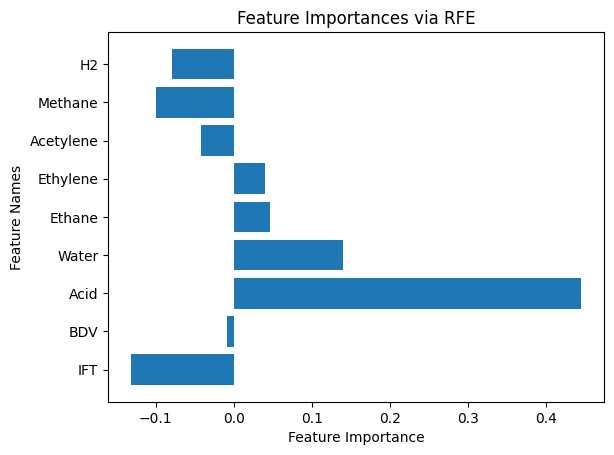

In [51]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Create linear regression
lr = LinearRegression()

# Create RFE with a desired number of features
rfe = RFE(lr, n_features_to_select=9) 

# Fit RFE
rfe.fit(X_A, y_A)

# Get ranking and importance scores
feature_ranks = rfe.ranking_
feature_importances = rfe.estimator_.coef_

# Get feature names
feature_names = X_A.columns

# Create plot
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Feature Importances via RFE")
plt.gca().invert_yaxis()

# Show plot
plt.show()

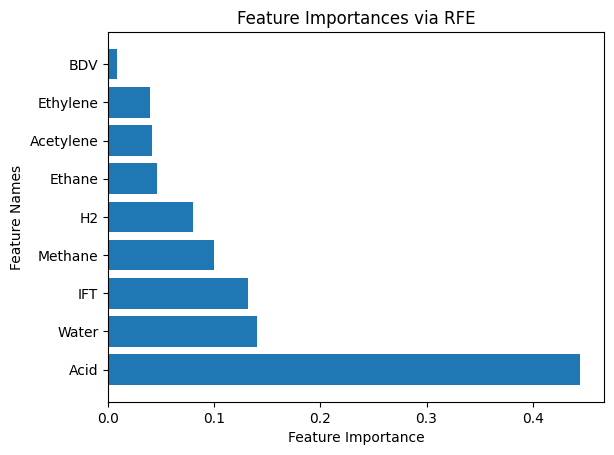

In [52]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Create linear regression
lr = LinearRegression()

# Create RFE with a desired number of features
rfe = RFE(lr, n_features_to_select=9) 

# Fit RFE
rfe.fit(X_A, y_A)

# Get ranking and importance scores
feature_ranks = rfe.ranking_
feature_importances = np.abs(rfe.estimator_.coef_)

# Get feature names
feature_names = X_A.columns

# Get index of sort order from feature importances
idx = feature_importances.argsort()  

# Sort feature importances
sorted_importances = feature_importances[idx]

# Sort feature names
sorted_features = feature_names[idx]

# Create plot
plt.barh(sorted_features, sorted_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Feature Importances via RFE")
plt.gca().invert_yaxis()

# Show plot
plt.show()

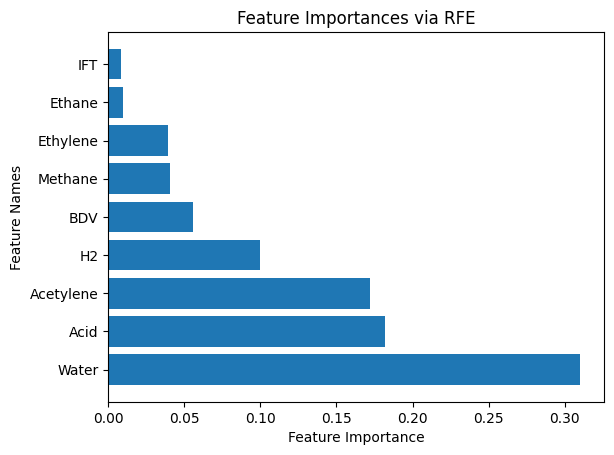

In [53]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Create linear regression
lr = LinearRegression()

# Create RFE with a desired number of features
rfe = RFE(lr, n_features_to_select=9) 

# Fit RFE
rfe.fit(X_B, y_B)

# Get ranking and importance scores
feature_ranks = rfe.ranking_
feature_importances = np.abs(rfe.estimator_.coef_)

# Get feature names
feature_names = X_B.columns

# Get index of sort order from feature importances
idx = feature_importances.argsort()  

# Sort feature importances
sorted_importances = feature_importances[idx]

# Sort feature names
sorted_features = feature_names[idx]

# Create plot
plt.barh(sorted_features, sorted_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Feature Importances via RFE")
plt.gca().invert_yaxis()

# Show plot
plt.show()

In [54]:
feature_importances

array([0.10006129, 0.04086189, 0.17237137, 0.03953432, 0.00985308,
       0.31024428, 0.18185046, 0.05563519, 0.00830315])

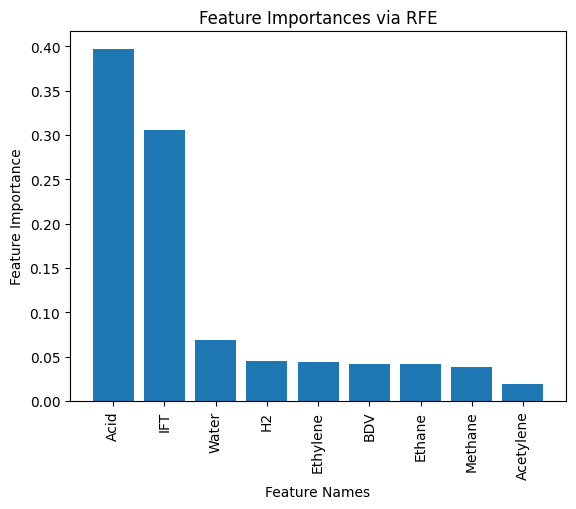

In [55]:
reg = ExtraTreesRegressor(random_state=43)

# Create RFE with a desired number of features
rfe = RFE(reg, n_features_to_select=9) 

# Fit RFE
rfe.fit(X_A, y_A)

# Get ranking and importance scores
feature_ranks = rfe.ranking_
feature_importances = np.abs(rfe.estimator_.feature_importances_)

# Get feature names
feature_names = X_A.columns

# Get index of sort order 
idx = feature_importances.argsort()[::-1] 

# Sort values and names  
sorted_importances = feature_importances[idx]
sorted_features = feature_names[idx]

# Create plot
plt.bar(sorted_features, sorted_importances)
plt.ylabel("Feature Importance") 
plt.xlabel("Feature Names")
plt.title("Feature Importances via RFE")

# Rotate x-tick labels
plt.xticks(rotation=90) 

# Show plot
plt.show()

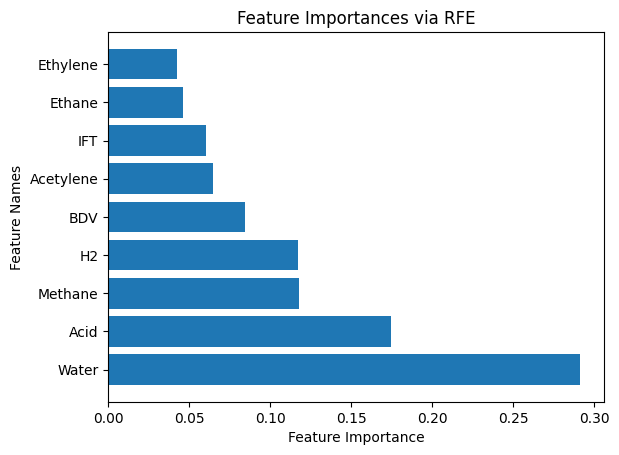

In [56]:
reg = ExtraTreesRegressor(random_state=40)

# Create RFE with a desired number of features
rfe = RFE(reg, n_features_to_select=9) 

# Fit RFE
rfe.fit(X_B, y_B)

# Get ranking and importance scores
feature_ranks = rfe.ranking_
feature_importances = np.abs(rfe.estimator_.feature_importances_)

# Get feature names
feature_names = X_B.columns

# Get index of sort order from feature importances
idx = feature_importances.argsort()  

# Sort feature importances
sorted_importances = feature_importances[idx]

# Sort feature names
sorted_features = feature_names[idx]

# Create plot
plt.barh(sorted_features, sorted_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Feature Importances via RFE")
plt.gca().invert_yaxis()

# Show plot
plt.show()

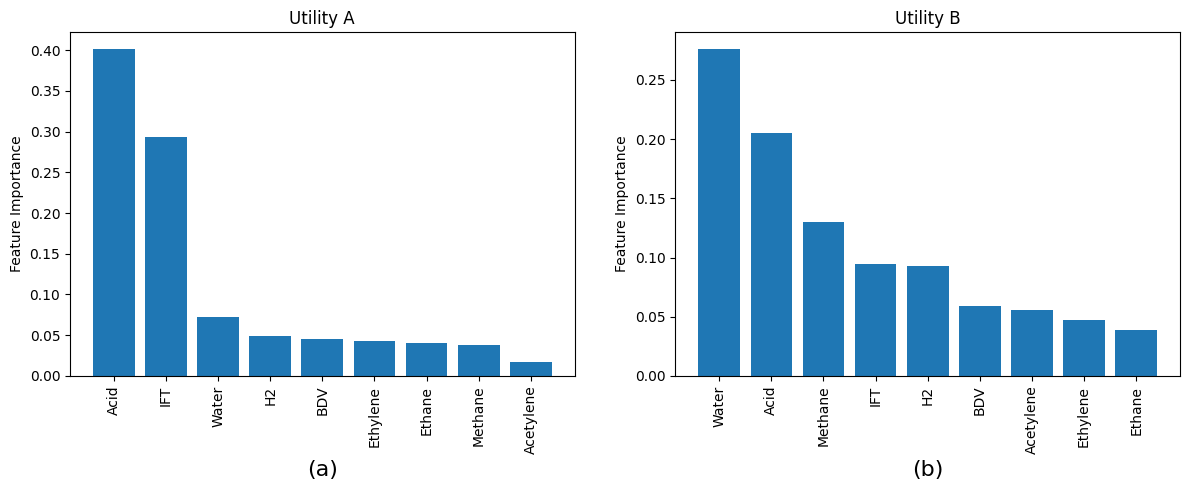

In [57]:
reg = ExtraTreesRegressor(random_state=41)

# Create RFE with a desired number of features
rfe = RFE(reg, n_features_to_select=9) 

# Fit RFE
rfe.fit(X_A, y_A)

# Get ranking and importance scores
feature_ranks = rfe.ranking_
feature_importances = np.abs(rfe.estimator_.feature_importances_)

# Get feature names
feature_names = X_A.columns

# Get index of sort order 
idx = feature_importances.argsort()[::-1]
sorted_importances_A = feature_importances[idx]
sorted_features_A = feature_names[idx]

# Create plot A
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(sorted_features_A, sorted_importances_A)
plt.ylabel("Feature Importance")
plt.xlabel("(a)", fontsize=16)
plt.title("Utility A")
plt.xticks(rotation=90)

# Create plot B
model = ExtraTreesRegressor(random_state=45)
model.fit(X_B, y_B)

# Obtain the feature importances from the trained model
importances = model.feature_importances_

# Sort the feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]
sorted_importances_B = importances[sorted_indices]

# Get the feature names in the original order
sorted_features_B = X_B.columns[sorted_indices]
'''
# Create RFE with a desired number of features
reg = ExtraTreesRegressor(random_state=43)
rfe = RFE(reg, n_features_to_select=9) 

# Fit RFE
rfe.fit(X_B, y_B)

# Get ranking and importance scores
feature_ranks = rfe.ranking_
feature_importances = np.abs(rfe.estimator_.feature_importances_)

# Get feature names
feature_names = X_B.columns

# Get index of sort order 
idx = feature_importances.argsort()[::-1]
sorted_importances_B = feature_importances[idx]
sorted_features_B = feature_names[idx]
'''
plt.subplot(1, 2, 2) 
plt.bar(sorted_features_B, sorted_importances_B)
plt.ylabel("Feature Importance")
plt.xlabel("(b)", fontsize=16)
plt.title("Utility B") 
plt.xticks(rotation=90)

# Adjust subplot spacing  
plt.tight_layout()

plt.subplots_adjust(wspace=0.2)
# Show plots
plt.savefig("figure.png")
plt.show()

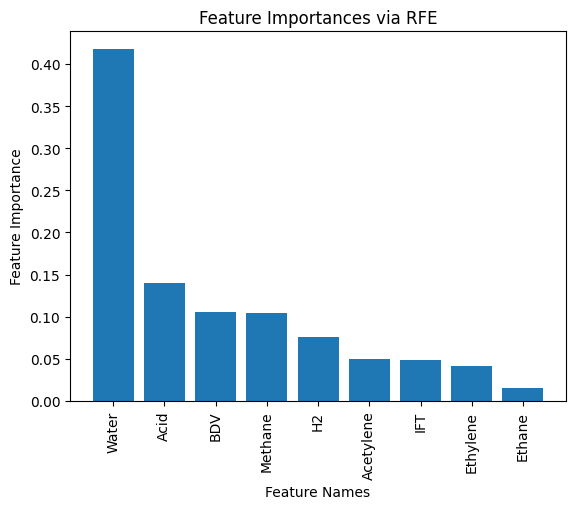

In [58]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(random_state=56)

# Create RFE with a desired number of features
rfe = RFE(reg, n_features_to_select=9) 

# Fit RFE
rfe.fit(X_B, y_B)

# Get ranking and importance scores
feature_ranks = rfe.ranking_
feature_importances = np.abs(rfe.estimator_.feature_importances_)

# Get feature names
feature_names = X_B.columns

# Get index of sort order 
idx = feature_importances.argsort()[::-1] 

# Sort values and names  
sorted_importances = feature_importances[idx]
sorted_features = feature_names[idx]

# Create plot
plt.bar(sorted_features, sorted_importances)
plt.ylabel("Feature Importance") 
plt.xlabel("Feature Names")
plt.title("Feature Importances via RFE")

# Rotate x-tick labels
plt.xticks(rotation=90) 

# Show plot
plt.show()

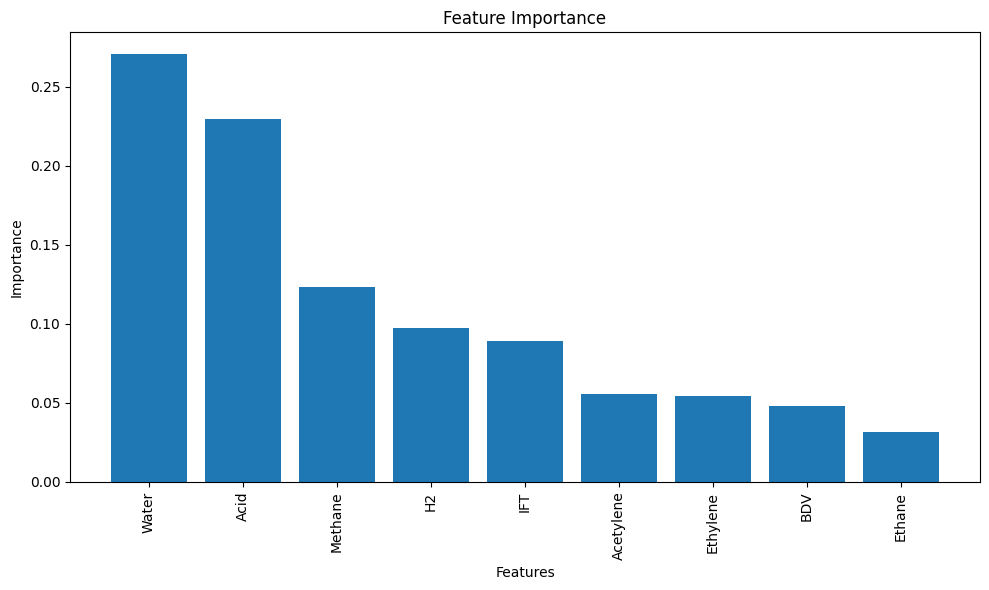

In [59]:
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor

# Train the ExtraTreesClassifier model
model = ExtraTreesRegressor(random_state=41)
model.fit(X_B, y_B)

# Obtain the feature importances from the trained model
importances = model.feature_importances_

# Sort the feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]

# Get the feature names in the original order
feature_names = X_B.columns[sorted_indices]

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()